In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import tqdm
from IPython.display import clear_output

In [2]:
class Battleship_board():
    def __init__(self):
        self.board = np.zeros((12,12))
        self.ships = [5,4,3,3,2]
        self.targets = np.ones((10,10)) * 0.5 # 0.5 is unknown, 1 is hit, 0 is miss
        self.place_ships()
        self.board = self.board[1:11,1:11] # remove the padding
        
    def place_ship(self, ship_size):
        placed = False
        for _ in range(100): # 100 attempts to place the ship
            x = np.random.randint(1,11)
            y = np.random.randint(1,11)
            direction = np.random.randint(4)
            if direction == 0:
                if x + ship_size < 10:
                    if np.sum(self.board[x-1:x+ship_size+1,y-1:y+2]) == 0:
                        self.board[x:x+ship_size,y] = 1
                        placed = True
            elif direction == 1:
                if y + ship_size < 10:
                    if np.sum(self.board[x-1:x+2,y-1:y+ship_size+2]) == 0:
                        self.board[x,y:y+ship_size] = 1
                        placed = True
            elif direction == 2:
                if x - ship_size > 1:
                    if np.sum(self.board[x-ship_size-1:x+1,y-1:y+2]) == 0:
                        self.board[x-ship_size:x,y] = 1
                        placed = True
            else:
                if y - ship_size > 1:
                    if np.sum(self.board[x-1:x+2,y-ship_size-1:y+1]) == 0:
                        self.board[x,y-ship_size:y] = 1
                        placed = True
            if placed:
                return self.board
            else:
                continue
    
    def place_ships(self):
        # shuffle the ships
        #np.random.shuffle(self.ships)
        for ship in self.ships:
            self.place_ship(ship)
        return self.board
    
    def display(self):
        plt.imshow(self.board)
        plt.show()
        
    def display_targets(self):
        plt.imshow(self.targets)
        plt.show()
    
    def fire(self, x, y):
        self.targets[x,y] = self.board[x,y]
    
    def random_fire(self):
        x = np.random.randint(10)
        y = np.random.randint(10)
        self.fire(x,y)
    
    def scatter_fire(self):
        random_firings = np.random.randint(200)
        if random_firings > 100: # cheat for known board state
            self.targets = self.board
        else:
            for _ in range(random_firings):
                self.random_fire()
    

In [3]:
# Define the neural network that will be used to predict the board
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*10*10, 128)
        self.fc2 = nn.Linear(128, 100)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64*10*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train(model, optimizer, criterion, n_epochs=1000):
    for epoch in tqdm.tqdm(range(n_epochs)):
        optimizer.zero_grad()
        board = Battleship_board()
        board.scatter_fire()
        board_tensor = torch.tensor(board.targets).unsqueeze(0).unsqueeze(0).float()
        output = model(board_tensor)
        loss = criterion(output, board_tensor.view(-1))
        loss.backward()
        optimizer.step()
        #if epoch % 100 == 0:
        #    print(loss.item())
    return model

In [4]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss();


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\Adam\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([1, 100])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10000/10000 [01:31<00:00, 109.54it/s]


In [11]:
model = train(model, optimizer, criterion, 10000)

100%|██████████| 10000/10000 [01:35<00:00, 104.60it/s]


In [12]:
turns = []

In [13]:
for game in tqdm.trange(1000):
    i = 0
    board = Battleship_board()
    while True: # play the game
        i += 1
        # predict the board
        board_tensor = torch.tensor(board.targets).unsqueeze(0).unsqueeze(0).float()
        output = model(board_tensor)
        output = output.view(10,10).detach().numpy()
        # find the highest probability spot not already fired at
        x, y = np.unravel_index( np.argmax(output), output.shape)
        while board.targets[x,y] != 0.5:
            output[x,y] = 0
            x, y = np.unravel_index(np.argmax(output), output.shape)
        board.fire(x,y)
        target_sum = np.sum(board.targets[board.targets == 1])
        if target_sum == board.board.sum():
            turns.append(i)
            break
        if i > 90:
            turns.append(i)
            break
            

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:43<00:00, 22.83it/s]


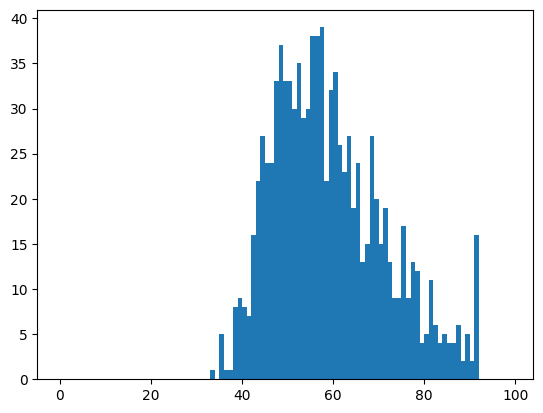

In [14]:
plt.hist(turns, bins=range(100));

In [15]:
print(np.mean(turns))

58.715


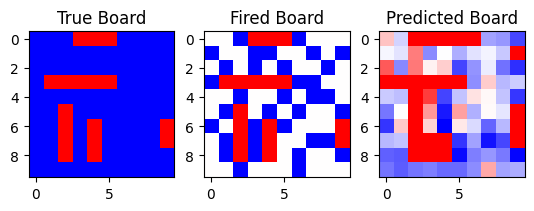

In [19]:
# animate the game
board = Battleship_board()
i = 0

while True: # play the game
    board_tensor = torch.tensor(board.targets).unsqueeze(0).unsqueeze(0).float()
    output = model(board_tensor)
    output = output.view(10,10).detach().numpy()
    
    
    # find the highest probability spot not already fired at
    x, y = np.unravel_index(np.argmax(output), output.shape)
    while board.targets[x,y] != 0.5:
        output[x,y] = 0
        x, y = np.unravel_index(np.argmax(output), output.shape)
    board.fire(x,y)
    target_sum = np.sum(board.targets[board.targets == 1])
    
    clear_output(wait=True)
    
    plt.subplot(1,3,1)
    plt.imshow(board.board, cmap='bwr')
    plt.title('True Board')
    plt.subplot(1,3,2)
    plt.imshow(board.targets, cmap='bwr')
    plt.title('Fired Board')
    plt.subplot(1,3,3)
    plt.imshow(-1 * output, cmap='bwr')
    plt.title('Predicted Board')
    plt.show()
    
    if target_sum == board.board.sum():
        break
    if i > 99:
        break
    i += 1